In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn


# For reproducible results
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    #np.random.seed(seed)
    #random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose( [transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(in_features=64 * 2 * 2, out_features=128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.bn1(self.relu(self.pool(self.conv1(x))))
        x = self.bn2(self.relu(self.pool(self.conv2(x))))
        x = self.bn3(self.relu(self.pool(self.conv3(x))))
        #print(x.shape)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x


network = NeuralNetwork()
network.to(device)

NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters())

In [8]:
network.train()
accuracy_train_list = []
accuracy_test_list = []
loss_epoch_train_list = []
loss_epoch_test_list = []

for epoch in range(1, 11):

    correct_train = 0
    correct_test = 0
    total_train = 0
    total_test = 0
    loss_epoch_train = 0
    loss_epoch_test = 0

    for data_train, data_test in zip(trainloader, testloader):

        inputs_train, labels_train = data_train[0].to(device), data_train[1].to(device)
        inputs_test, labels_test = data_test[0].to(device), data_test[1].to(device)

        optimizer.zero_grad()

        outputs_train = network(inputs_train)
        loss_train = criterion(outputs_train, labels_train)
        loss_train.backward()
        optimizer.step()

        loss_epoch_train += loss_train.item()
        
        network.eval()
        with torch.no_grad():
            outputs_test = network(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            loss_epoch_test += loss_test.item()
            _, predicted_test = torch.max(outputs_test.data, 1)
            total_test += labels_test.size(0)
            correct_test += (predicted_test == labels_test).sum().item()

            outputs_train_eval = network(inputs_train)
            _, predicted_train = torch.max(outputs_train_eval.data, 1)
            total_train += labels_train.size(0)
            correct_train += (predicted_train == labels_train).sum().item()

        network.train()
        
        
    loss_epoch_train_list.append(loss_epoch_train/len(trainloader))
    loss_epoch_test_list.append(loss_epoch_test/len(testloader))
    accuracy_train_list.append(100 * correct_train / total_train)
    accuracy_test_list.append(100 * correct_test / total_test)

    print(f'Epoch {epoch} - Train loss: {loss_epoch_train/len(trainloader):.3f}  \
           - Test loss: {loss_epoch_test/len(testloader):.3f} - Train accuracy: {100 * correct_train / (total_train):.3f} \
           - Test accuracy: {100 * correct_test / (total_test):.3f}')

Epoch 1 - Train loss: 0.434             - Test loss: 2.227 - Train accuracy: 16.152            - Test accuracy: 16.370
Epoch 2 - Train loss: 0.366             - Test loss: 1.931 - Train accuracy: 24.678            - Test accuracy: 24.420
Epoch 3 - Train loss: 0.324             - Test loss: 1.582 - Train accuracy: 42.227            - Test accuracy: 42.030
Epoch 4 - Train loss: 0.300             - Test loss: 1.412 - Train accuracy: 48.750            - Test accuracy: 48.200
Epoch 5 - Train loss: 0.283             - Test loss: 1.323 - Train accuracy: 52.490            - Test accuracy: 51.780
Epoch 6 - Train loss: 0.270             - Test loss: 1.269 - Train accuracy: 55.293            - Test accuracy: 54.100
Epoch 7 - Train loss: 0.260             - Test loss: 1.219 - Train accuracy: 57.207            - Test accuracy: 56.050
Epoch 8 - Train loss: 0.252             - Test loss: 1.175 - Train accuracy: 59.482            - Test accuracy: 57.600
Epoch 9 - Train loss: 0.243             - Test l

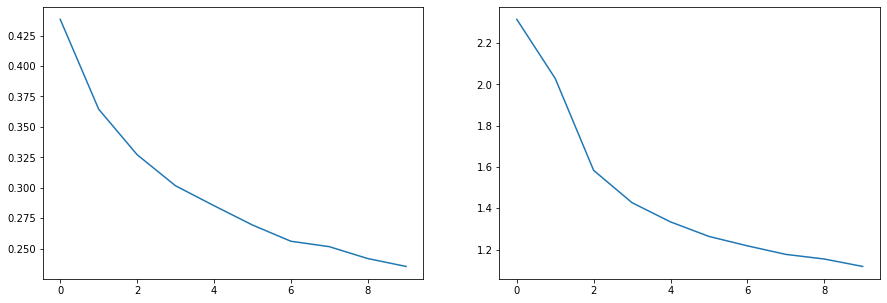

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss_epoch_train_list, label='Train loss')
ax[1].plot(loss_epoch_test_list, label='Test loss')

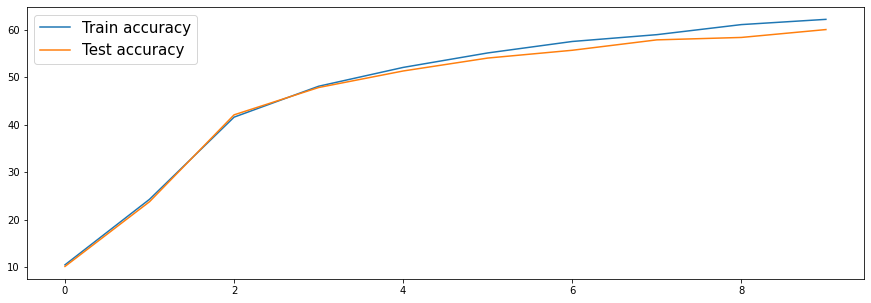

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(accuracy_train_list, label='Train accuracy')
ax.plot(accuracy_test_list, label='Test accuracy')
ax.legend(prop={'size': 15})

In [ ]:
# Base accuracy should be around 10% (random guessing)

In [9]:
predicted_test = []
labels_test = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_test.extend(predicted.cpu().numpy())
        labels_test.extend(labels.cpu().numpy())

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(labels_test, predicted_test, target_names=classes))

              precision    recall  f1-score   support

       plane       0.65      0.56      0.60      1000
         car       0.72      0.73      0.72      1000
        bird       0.49      0.37      0.42      1000
         cat       0.38      0.33      0.35      1000
        deer       0.51      0.45      0.48      1000
         dog       0.49      0.52      0.50      1000
        frog       0.66      0.68      0.67      1000
       horse       0.58      0.70      0.64      1000
        ship       0.63      0.78      0.70      1000
       truck       0.65      0.71      0.68      1000

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



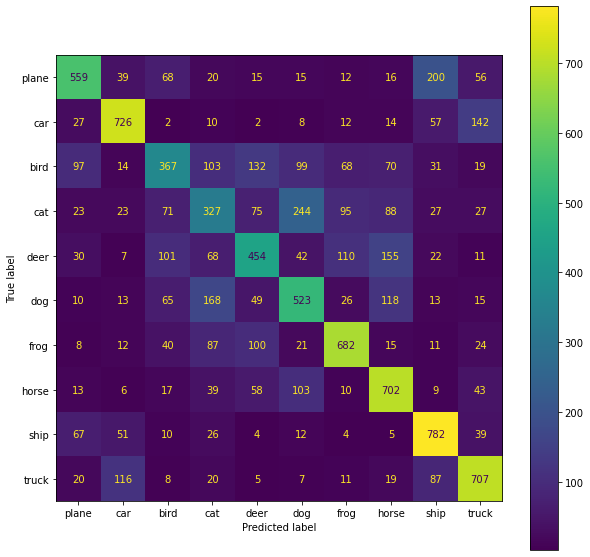

In [19]:
cm = confusion_matrix(labels_test, predicted_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

<h1>Transfer Learning</h1>

In [12]:
from torchvision import models

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(512, 10)
resnet.to(device)

/home/cosmos/mambaforge/envs/th/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/cosmos/mambaforge/envs/th/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters())

In [39]:
resnet.train()
accuracy_train_list = []
accuracy_test_list = []
loss_epoch_train_list = []
loss_epoch_test_list = []

for epoch in range(1, 11):

    correct_train = 0
    correct_test = 0
    total_train = 0
    total_test = 0
    loss_epoch_train = 0
    loss_epoch_test = 0

    for data_train, data_test in zip(trainloader, testloader):

        inputs_train, labels_train = data_train[0].to(device), data_train[1].to(device)
        inputs_test, labels_test = data_test[0].to(device), data_test[1].to(device)

        optimizer.zero_grad()

        outputs_train = resnet(inputs_train)
        loss_train = criterion(outputs_train, labels_train)
        loss_train.backward()
        optimizer.step()

        loss_epoch_train += loss_train.item()
        
        resnet.eval()
        with torch.no_grad():
            outputs_test = resnet(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            loss_epoch_test += loss_test.item()
            _, predicted_test = torch.max(outputs_test.data, 1)
            total_test += labels_test.size(0)
            correct_test += (predicted_test == labels_test).sum().item()

            outputs_train_eval = resnet(inputs_train)
            _, predicted_train = torch.max(outputs_train_eval.data, 1)
            total_train += labels_train.size(0)
            correct_train += (predicted_train == labels_train).sum().item()

        resnet.train()
        
        
    loss_epoch_train_list.append(loss_epoch_train/len(trainloader))
    loss_epoch_test_list.append(loss_epoch_test/len(testloader))
    accuracy_train_list.append(100 * correct_train / total_train)
    accuracy_test_list.append(100 * correct_test / total_test)

    print(f'Epoch {epoch} - Train loss: {loss_epoch_train/len(trainloader):.3f}  \
           - Test loss: {loss_epoch_test/len(testloader):.3f} - Train accuracy: {100 * correct_train / (total_train):.3f} \
           - Test accuracy: {100 * correct_test / (total_test):.3f}')

Epoch 1 - Train loss: 0.280             - Test loss: 1.851 - Train accuracy: 42.139            - Test accuracy: 40.650
Epoch 2 - Train loss: 0.168             - Test loss: 1.079 - Train accuracy: 68.643            - Test accuracy: 65.290
Epoch 3 - Train loss: 0.138             - Test loss: 0.820 - Train accuracy: 77.920            - Test accuracy: 72.160
Epoch 4 - Train loss: 0.124             - Test loss: 0.762 - Train accuracy: 79.951            - Test accuracy: 74.270
Epoch 5 - Train loss: 0.110             - Test loss: 0.719 - Train accuracy: 83.574            - Test accuracy: 76.310
Epoch 6 - Train loss: 0.101             - Test loss: 0.715 - Train accuracy: 84.092            - Test accuracy: 76.630
Epoch 7 - Train loss: 0.096             - Test loss: 0.687 - Train accuracy: 85.068            - Test accuracy: 77.650
Epoch 8 - Train loss: 0.088             - Test loss: 0.690 - Train accuracy: 86.543            - Test accuracy: 77.780
Epoch 9 - Train loss: 0.080             - Test l

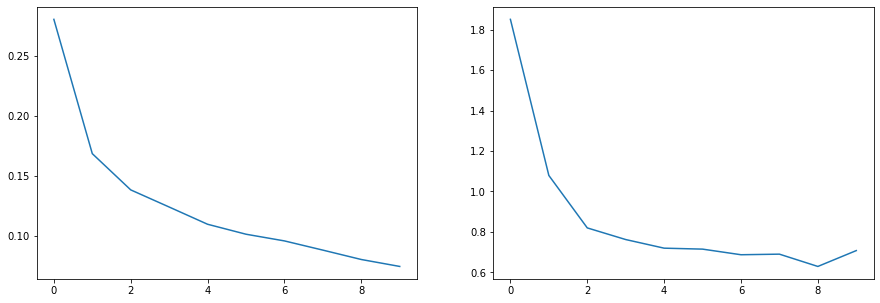

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss_epoch_train_list, label='Train loss')
ax[1].plot(loss_epoch_test_list, label='Test loss')

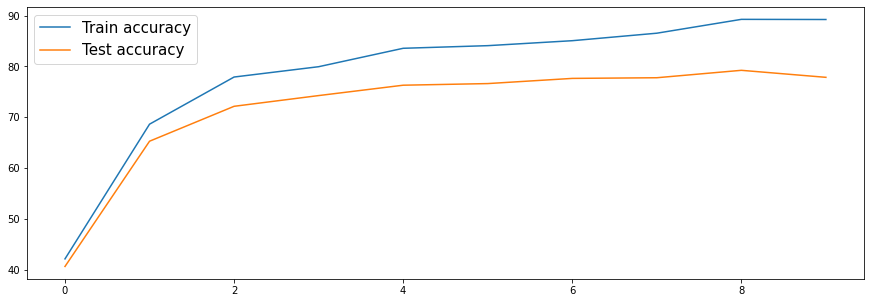

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(accuracy_train_list, label='Train accuracy')
ax.plot(accuracy_test_list, label='Test accuracy')
ax.legend(prop={'size': 15})

In [42]:
predicted_test = []
labels_test = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_test.extend(predicted.cpu().numpy())
        labels_test.extend(labels.cpu().numpy())

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(labels_test, predicted_test, target_names=classes))

              precision    recall  f1-score   support

       plane       0.78      0.86      0.82      1000
         car       0.91      0.84      0.87      1000
        bird       0.80      0.70      0.74      1000
         cat       0.62      0.66      0.64      1000
        deer       0.74      0.83      0.78      1000
         dog       0.78      0.62      0.69      1000
        frog       0.83      0.85      0.84      1000
       horse       0.80      0.88      0.84      1000
        ship       0.89      0.88      0.88      1000
       truck       0.86      0.86      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



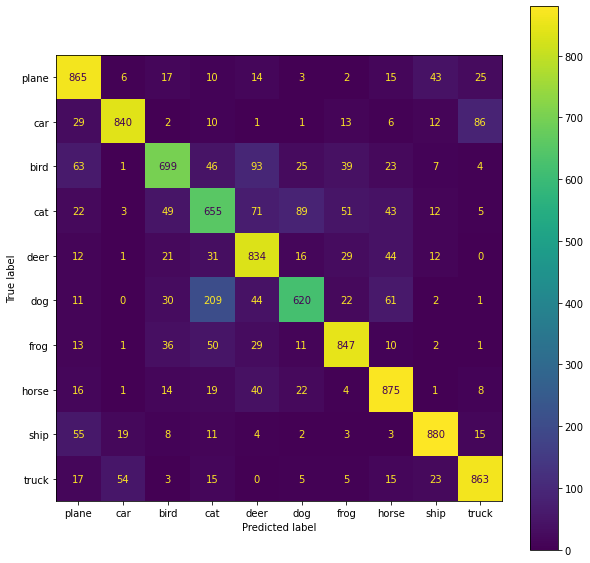

In [44]:
cm = confusion_matrix(labels_test, predicted_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)